In [2]:
import pandas as pd
import numpy as np
import gzip
import json
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import geopandas as gpd
from collections import defaultdict

# CSE 158 Assignment 2

### Issac, Rushi, Ty, Noah

This project analyzes Google Local business data to predict whether a user will review a business. We use exploratory data analysis (EDA) to understand patterns in user behavior, business characteristics, and review distributions. We build and evaluate multiple models, including baseline popularity-based approaches and collaborative filtering, to predict user-business review interactions. The models are evaluated using standard classification metrics (accuracy, precision, recall, F1-score) to identify the most effective approach for this prediction task.

## Table of Contents

- **Data**
- **EDA**
- **Selecting Topics**
- **Modeling**
- **Evaluation**
- **Conclusion**

## Data

We chose to go with the [Google Local Data (2021)](https://mcauleylab.ucsd.edu/public_datasets/gdrive/googlelocal/) because it had a LOT of data. In fact, it had too much data, having millions of data points. Because of this, we decided to filter the data down to businesses in San Diego. We'll begin by importing our data and taking a look at some sample data points.

In [4]:
meta_sd = []
with gzip.open("Data/meta-SanDiego.json.gz", "rt", encoding="utf-8") as f:
    for line in f:
        meta_sd.append(json.loads(line))
        
review_sd = []
for i in range(1, 5):
    with gzip.open(f"Data/review-SanDiego_10_file{i}.json.gz", "rt", encoding="utf-8") as f:
        for line in f:
            review_sd.append(json.loads(line))
            
location_dict = {b['gmap_id']: (b['latitude'],b['longitude']) for b in meta_sd}
review_coords = [location_dict[review_sd[i]['gmap_id']] for i in range(len(review_sd))]
filtered_review_locations = [
    tup for tup in review_coords
    if tup[1] < -116.5
    and tup[0] < 33.8
]

lats = list()
longs = list()
for lat, long in filtered_review_locations:
    lats.append(lat)
    longs.append(long)

In [5]:
meta_sd[0]

{'name': 'HDR',
 'address': 'HDR, 591 Camino De La Reina suite 300, San Diego, CA 92108',
 'gmap_id': '0x80dbffc64011f711:0x6d7970e6968f3f92',
 'description': None,
 'latitude': 32.765555,
 'longitude': -117.16167399999999,
 'category': ['Engineering consultant',
  'Architecture firm',
  'Civil engineering company',
  'Construction company',
  'Environmental engineer'],
 'avg_rating': 5,
 'num_of_reviews': 3,
 'price': None,
 'hours': [['Thursday', '8AM–5PM'],
  ['Friday', '8AM–5PM'],
  ['Saturday', 'Closed'],
  ['Sunday', 'Closed'],
  ['Monday', '8AM–5PM'],
  ['Tuesday', '8AM–5PM'],
  ['Wednesday', '8AM–5PM']],
 'MISC': {'Accessibility': ['Wheelchair accessible entrance']},
 'state': 'Open ⋅ Closes 5PM',
 'relative_results': ['0x80dbff98570bd5a1:0x53a6df3b4d73da85',
  '0x80d9538e0c2e60a7:0xfb635fe02b1e06a7',
  '0x80dc06d36b327ac1:0x39bab4445058dded',
  '0x80dbfe4ca26f4b73:0x1bda90d940f9cbc8',
  '0x80dbffb6cf816d2f:0x25a53967cb9bc656'],
 'url': 'https://www.google.com/maps/place//data=

In [6]:
review_sd[0]

{'user_id': '102919413961325598675',
 'name': 'Humberto Garcia Jr.',
 'time': 1569188767987,
 'rating': 4,
 'text': 'Definitely something worth trying. If you’ve never had Hard Kombucha you need to come here. It’s very different and the inside is beautiful. They have a variety of games and there is plenty of seating.',
 'pics': [{'url': ['https://lh5.googleusercontent.com/p/AF1QipOQvLGEgw3N8Q6ZuF-6-bTuJsJyc5w_hRqhcDmK=w150-h150-k-no-p']},
  {'url': ['https://lh5.googleusercontent.com/p/AF1QipNpJMOyc4I4x1ZtgV8OJ6zEdSyyRO34Y9Ug2GIT=w150-h150-k-no-p']},
  {'url': ['https://lh5.googleusercontent.com/p/AF1QipNbBgiCUpVcEA8yn_ZqpfyTnK5OLxBRyIAdnLA2=w150-h150-k-no-p']},
  {'url': ['https://lh5.googleusercontent.com/p/AF1QipNToM7NgDO_WrCWM0L0sX9kpYIQryoxdEpUP8kT=w150-h150-k-no-p']}],
 'resp': None,
 'gmap_id': '0x80dc7588a897ed91:0x190ac94f6ebb8c76'}

## EDA

#### Spatial Distribution of Reviews

We analyzed the geographic distribution of reviews across San Diego County using a heatmap. The visualization shows review density on a logarithmic scale, with brighter colors indicating higher concentrations. The data reveals a strong concentration along the coastal and central urban areas, with distinct hotspots in densely populated regions. 

This spatial pattern suggests that review activity is closely tied to population density and urban development, which makes sense since more developed areas tend to have more businesses. What's more interesting is the sparse patches between the dense areas which are likely results from zoning for non-commercial areas such as residential/industrial areas.

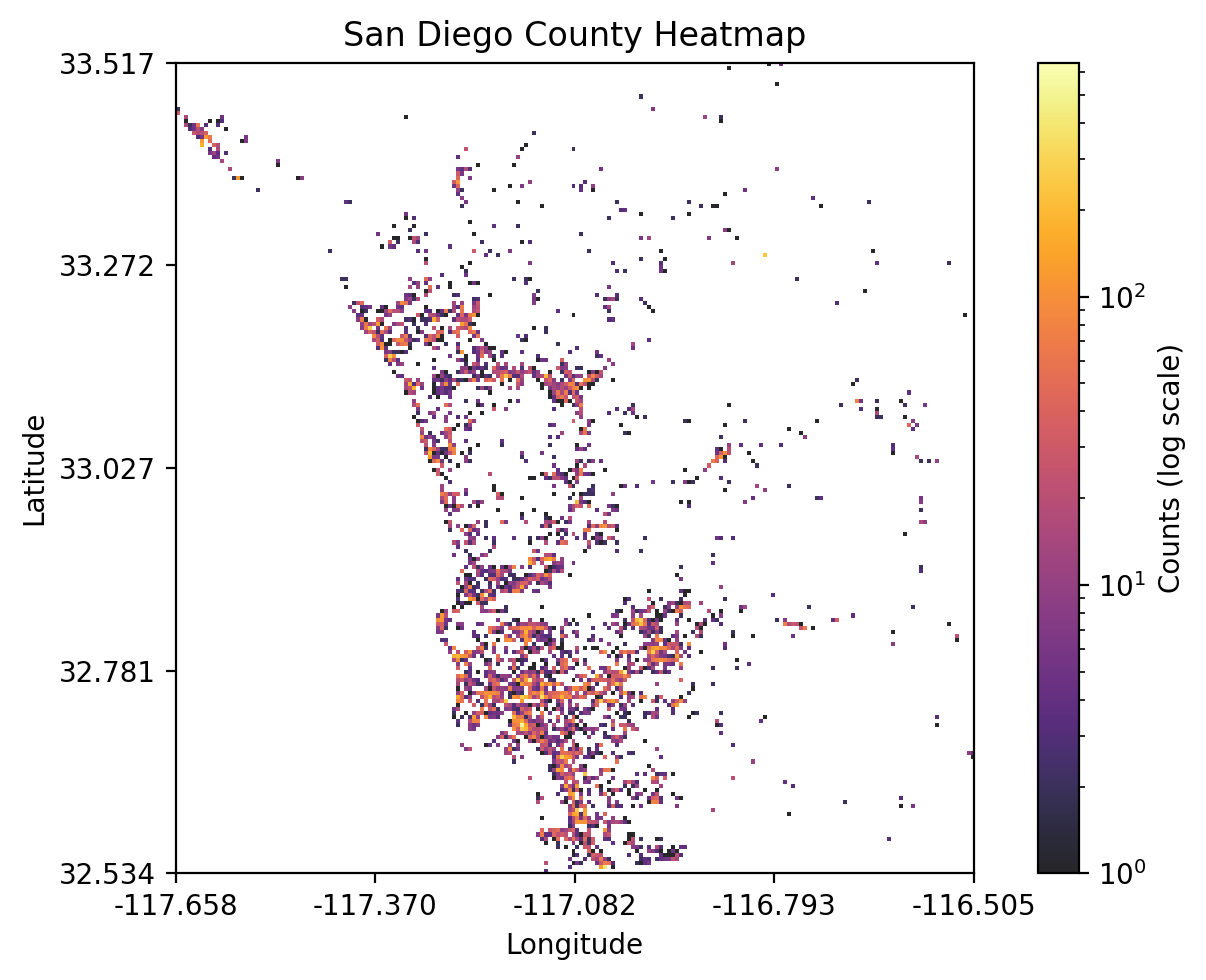

In [7]:
BINS = 200
DPI = 200
ALPHA = 0.85
CMAP = "inferno"

def flatten_numeric(arr):
    arr = np.array(arr, dtype=object).reshape(-1)
    out = []
    for x in arr:
        try:
            if isinstance(x, (float, int, np.floating, np.integer)):
                out.append(float(x))
            elif isinstance(x, (list, tuple, np.ndarray)):
                out.append(float(np.array(x).reshape(-1)[0]))
            else:
                out.append(float(x))
        except:
            continue
    return np.array(out, dtype=float)

lon = flatten_numeric(longs)
lat = flatten_numeric(lats)

m = min(len(lon), len(lat))
lon = lon[:m]
lat = lat[:m]

mask = np.isfinite(lon) & np.isfinite(lat)
lon = lon[mask]
lat = lat[mask]

if len(lon) > 60000:
    idx = np.random.choice(len(lon), 60000, replace=False)
    lon = lon[idx]
    lat = lat[idx]

R = 6378137.0
mx = lon * (R * np.pi/180)
lat_clip = np.clip(lat, -85.05112878, 85.05112878)
my = R * np.log(np.tan(np.pi/4 + np.radians(lat_clip)/2))
mx = mx.reshape(-1)
my = my.reshape(-1)

H, xedges, yedges = np.histogram2d(mx, my, bins=BINS)

fig, ax = plt.subplots(figsize=(7,5), dpi=DPI)

nonzero = H[H > 0]
vmin = max(1, nonzero.min()) if nonzero.size else 1
vmax = max(1, H.max())

ax.imshow(
    H.T,
    origin='lower',
    cmap=CMAP,
    norm=LogNorm(vmin=vmin, vmax=vmax),
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    alpha=ALPHA,
    interpolation='nearest'
)

def inv_merc_x(x): return x / (R * np.pi/180)
def inv_merc_y(y): return np.degrees(2*np.arctan(np.exp(y/R)) - np.pi/2)

xticks = np.linspace(xedges[0], xedges[-1], 5)
yticks = np.linspace(yedges[0], yedges[-1], 5)

ax.set_xticks(xticks)
ax.set_xticklabels([f"{inv_merc_x(v):.3f}" for v in xticks])
ax.set_yticks(yticks)
ax.set_yticklabels([f"{inv_merc_y(v):.3f}" for v in yticks])

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.colorbar(ax.images[-1], ax=ax, label="Counts (log scale)")
ax.set_title("San Diego County Heatmap")
plt.tight_layout()
plt.show()

#### Distribution of Review Characteristics

We examined the distributions of review text length and ratings. The review length histogram is right-skewed, with most reviews very short (near 0 characters) and counts dropping sharply as length increases. Few reviews exceed 1000 characters. 

The rating distribution shows a strong positive bias: 5-star ratings are most common (over 700,000), followed by 4-star (around 250,000), with 1–3 stars much less frequent. Another insight is that 2-star reviews are the least common since people tend to have polarized emotions. 

This suggests users tend to leave short reviews and rate businesses highly, which may inform feature engineering and model assumptions.

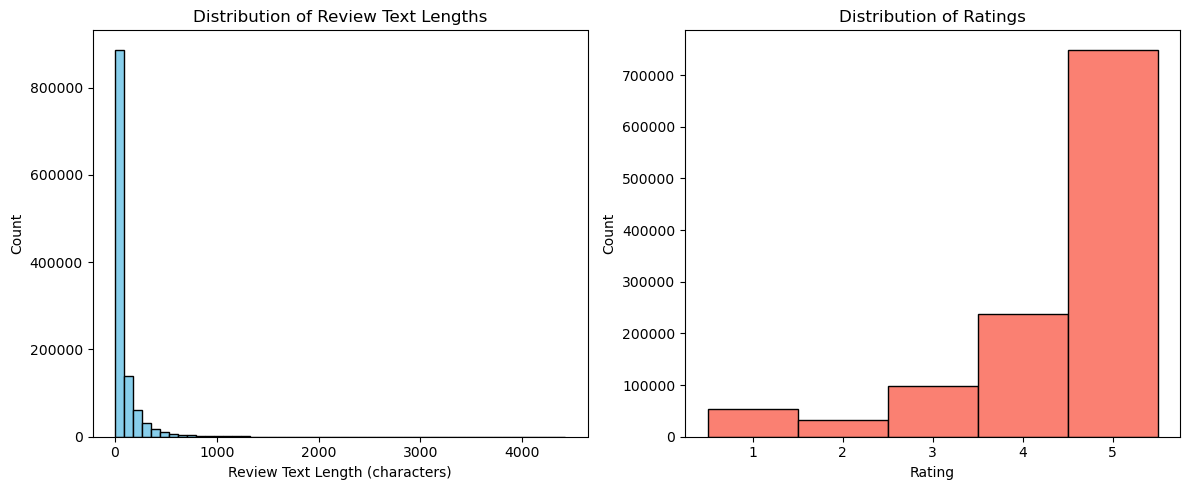

In [8]:
review_lens = [
    len(r.get("text") or "")
    for r in review_sd
]

ratings = [
    int(r.get("rating", 0))
    for r in review_sd
    if r.get("rating") is not None
]

review_lens = np.array(review_lens)
ratings = np.array(ratings)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(review_lens, bins=50, color="skyblue", edgecolor="black")
plt.xlabel("Review Text Length (characters)")
plt.ylabel("Count")
plt.title("Distribution of Review Text Lengths")

plt.subplot(1,2,2)
plt.hist(ratings, bins=np.arange(0.5,6.5,1), color="salmon", edgecolor="black")
plt.xticks([1,2,3,4,5])
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings")

plt.tight_layout()
plt.show()

#### Relationship Between Price Level and Ratings

We analyzed how business price level relates to average ratings. Ratings were normalized to compare across price categories. The results show a positive correlation: lower price levels  tend to have below-average normalized ratings, while higher price levels tend to have above-average normalized ratings.

C:\Users\issac\AppData\Local\Temp\ipykernel_31168\1338457717.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_stats = df_price.groupby('price')['rating'].agg(['mean','std','count']).reset_index()


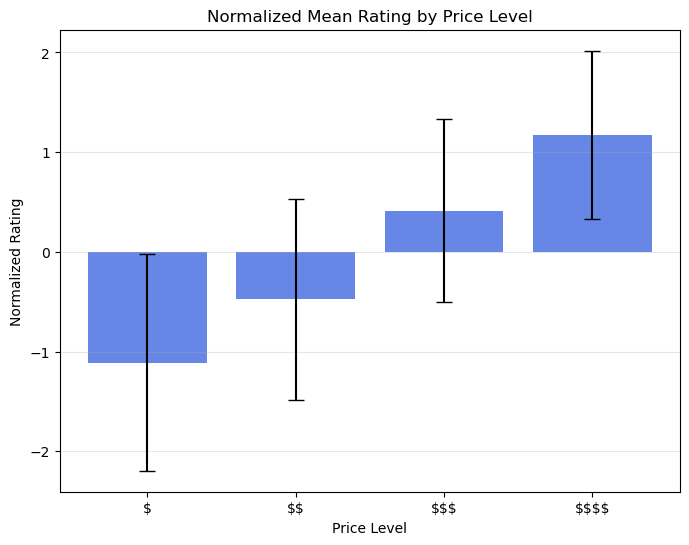

In [ ]:
prices = {b['gmap_id']: b['price'] for b in meta_sd if b['price'] != None}

rows = []

for r in review_sd:
    gmap = r['gmap_id']
    rating = r.get('rating')

    if rating is None:
        continue

    price = prices.get(gmap)
    if price in ['$','$$','$$$','$$$$']:
        rows.append({'price': price, 'rating': rating})

df_price = pd.DataFrame(rows)

price_order = ['$', '$$', '$$$', '$$$$']
df_price['price'] = pd.Categorical(df_price['price'], categories=price_order, ordered=True)
df_stats = df_price.groupby('price')['rating'].agg(['mean','std','count']).reset_index()
df_stats['normalized_mean'] = (df_stats['mean'] - df_stats['mean'].mean()) / df_stats['mean'].std()
plt.figure(figsize=(8,6))

plt.bar(
    ['\\$','\\$\\$','\\$\\$\\$','\\$\\$\\$\\$'], 
    df_stats['normalized_mean'],
    yerr=df_stats['std'],
    capsize=6,
    color='royalblue',
    alpha=0.8
)

plt.xlabel("Price Level")
plt.ylabel("Normalized Rating")
plt.title("Normalized Mean Rating by Price Level")
plt.grid(axis='y', alpha=0.3)

plt.show()

#### Significance Between Price Level and Ratings

Next we wanted to see if the relationship we just found is significant or not. In order to do this, we can run a one-way ANOVA as well as a Krusekal-Wallis test to find the significance of this relationship. Doing so reveals that there is in fact a significant relationship. However, the effect size is small with only 0.24\% of the data variance in ratings being explained by price level.

In [18]:
from scipy.stats import f_oneway, kruskal
import numpy as np

price_rating_groups = []
for price_level in ['$', '$$', '$$$', '$$$$']:
    ratings = df_price[df_price['price'] == price_level]['rating'].dropna().tolist()
    if len(ratings) >= 2:
        price_rating_groups.append([float(r) for r in ratings])

print(f"Price levels with sufficient data: {len(price_rating_groups)}")
print(f"Total ratings: {sum(len(g) for g in price_rating_groups)}\n")

print("=" * 60)
print("ONE-WAY ANOVA")
print("=" * 60)
f_stat, p_anova = f_oneway(*price_rating_groups)
print(f"F-statistic: {f_stat:.4f}, P-value: {p_anova:.2e}")

# Calculate eta-squared (effect size for ANOVA)
all_ratings = np.concatenate(price_rating_groups)
grand_mean = np.mean(all_ratings)
ss_between = sum(len(group) * (np.mean(group) - grand_mean)**2 for group in price_rating_groups)
ss_total = sum((rating - grand_mean)**2 for rating in all_ratings)
eta_squared = ss_between / ss_total if ss_total > 0 else 0

print(f"Eta-squared (η²): {eta_squared:.4f}")
print(f"Result: {'Significant' if p_anova < 0.05 else 'Not significant'} (α=0.05)\n")

print("=" * 60)
print("KRUSKAL-WALLIS TEST")
print("=" * 60)
h_stat, p_kw = kruskal(*price_rating_groups)
print(f"H-statistic: {h_stat:.4f}, P-value: {p_kw:.2e}")

# Calculate epsilon-squared (effect size for Kruskal-Wallis)
n_total = sum(len(group) for group in price_rating_groups)
epsilon_squared = (h_stat - (len(price_rating_groups) - 1)) / (n_total - len(price_rating_groups))
epsilon_squared = max(0, epsilon_squared)  # Ensure non-negative

print(f"Epsilon-squared (ε²): {epsilon_squared:.4f}")
print(f"Result: {'Significant' if p_kw < 0.05 else 'Not significant'} (α=0.05)\n")

print("=" * 60)
print("SUMMARY")
print("=" * 60)
if p_anova < 0.05 and p_kw < 0.05:
    print("Both tests: Significant relationship between price level and rating")
    print(f"Effect size (η²): {eta_squared:.4f} - ", end="")
    if eta_squared < 0.01:
        print("Small effect")
    elif eta_squared < 0.06:
        print("Medium effect")
    else:
        print("Large effect")
elif p_anova < 0.05 or p_kw < 0.05:
    print("Mixed results: One test significant")
else:
    print("Both tests: No significant relationship")

Price levels with sufficient data: 4
Total ratings: 536554

ONE-WAY ANOVA
F-statistic: 434.8074, P-value: 3.56e-282
Eta-squared (η²): 0.0024
Result: Significant (α=0.05)

KRUSKAL-WALLIS TEST
H-statistic: 1107.3471, P-value: 9.27e-240
Epsilon-squared (ε²): 0.0021
Result: Significant (α=0.05)

SUMMARY
Both tests: Significant relationship between price level and rating
Effect size (η²): 0.0024 - Small effect


#### Relationship Between Categories and Ratings

Next we wanted to see if the Category variable could potentially explain the variance in rating better. Each business belongs to multiple categories and there end up being ~3000 unique categories. Because of this, we'll only take a look at the 20 most reviewed categories in our bar graph.

In [11]:
categories = {b['gmap_id']: b['category'] for b in meta_sd}

categories_ratings = defaultdict(list)
for r in review_sd:
    cats = categories.get(r['gmap_id'])
    rating = r.get('rating')
    if cats and rating is not None:
        cats_list = cats if isinstance(cats, list) else [cats]
        for cat in cats_list:
            categories_ratings[cat].append(rating)

df_cat = pd.DataFrame([
    {
        'category': cat,
        'weighted_mean': np.array(ratings, dtype=float).mean(),
        'num_reviews': len(ratings)
    }
    for cat, ratings in categories_ratings.items()
]).sort_values('num_reviews', ascending=False)

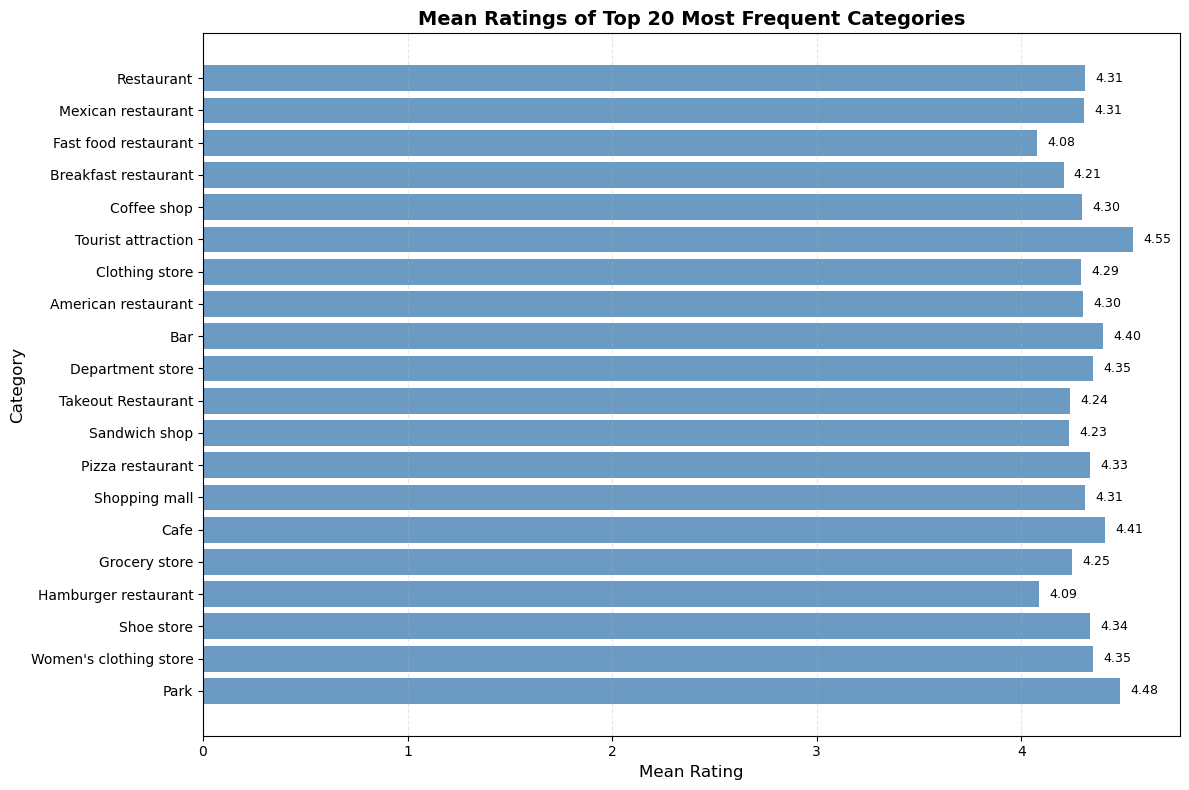

In [12]:
top_20_categories = df_cat.head(20)

# Create bar chart
plt.figure(figsize=(12, 8))
bars = plt.barh(
    range(len(top_20_categories)),
    top_20_categories['weighted_mean'],
    color='steelblue',
    alpha=0.8
)

# Set y-axis labels to category names
plt.yticks(range(len(top_20_categories)), top_20_categories['category'])
plt.xlabel('Mean Rating', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.title('Mean Ratings of Top 20 Most Frequent Categories', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3, linestyle='--')

# Add value labels on bars
for i, (idx, row) in enumerate(top_20_categories.iterrows()):
    plt.text(row['weighted_mean'] + 0.05, i, f"{row['weighted_mean']:.2f}", 
             va='center', fontsize=9)

# Reverse y-axis so highest frequency is at top
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

#### Significance Between Category and Ratings

Again, we can see some variance in mean ratings but we wanted to see if the relationship we just found is significant or not. In order to do this, we can again run a one-way ANOVA as well as a Krusekal-Wallis test to find the significance of this relationship. Doing so reveals that there is in fact a significant relationship. This time, we find a slightly larger effect size at 2.9% indicating that Category is a better predictor of Rating that Price Level.

In [19]:
from scipy.stats import f_oneway, kruskal

category_rating_groups = [
    [float(r) for r in ratings if r is not None]
    for ratings in categories_ratings.values()
    if len([r for r in ratings if r is not None]) >= 2
]

print(f"Categories with sufficient data: {len(category_rating_groups)}")
print(f"Total ratings: {sum(len(g) for g in category_rating_groups)}\n")

print("=" * 60)
print("ONE-WAY ANOVA")
print("=" * 60)
f_stat, p_anova = f_oneway(*category_rating_groups)
print(f"F-statistic: {f_stat:.4f}, P-value: {p_anova:.2e}")

all_ratings = np.concatenate(category_rating_groups)
grand_mean = np.mean(all_ratings)
ss_between = sum(len(group) * (np.mean(group) - grand_mean)**2 for group in category_rating_groups)
ss_total = sum((rating - grand_mean)**2 for rating in all_ratings)
eta_squared = ss_between / ss_total if ss_total > 0 else 0

print(f"Eta-squared (η²): {eta_squared:.4f}")
print(f"Result: {'Significant' if p_anova < 0.05 else 'Not significant'} (α=0.05)\n")

print("=" * 60)
print("KRUSKAL-WALLIS TEST")
print("=" * 60)
h_stat, p_kw = kruskal(*category_rating_groups)
print(f"H-statistic: {h_stat:.4f}, P-value: {p_kw:.2e}")

n_total = sum(len(group) for group in category_rating_groups)
epsilon_squared = (h_stat - (len(category_rating_groups) - 1)) / (n_total - len(category_rating_groups))
epsilon_squared = max(0, epsilon_squared)

print(f"Epsilon-squared (ε²): {epsilon_squared:.4f}")
print(f"Result: {'Significant' if p_kw < 0.05 else 'Not significant'} (α=0.05)\n")

print("=" * 60)
print("SUMMARY")
print("=" * 60)
if p_anova < 0.05 and p_kw < 0.05:
    print("Both tests: Significant relationship between category and rating")
    print(f"Effect size (η²): {eta_squared:.4f} - ", end="")
    if eta_squared < 0.01:
        print("Small effect")
    elif eta_squared < 0.06:
        print("Medium effect")
    else:
        print("Large effect")
elif p_anova < 0.05 or p_kw < 0.05:
    print("Mixed results: One test significant")
else:
    print("Both tests: No significant relationship")

Categories with sufficient data: 2304
Total ratings: 3569821

ONE-WAY ANOVA
F-statistic: 46.1974, P-value: 0.00e+00
Eta-squared (η²): 0.0290
Result: Significant (α=0.05)

KRUSKAL-WALLIS TEST
H-statistic: 108186.5826, P-value: 0.00e+00
Epsilon-squared (ε²): 0.0297
Result: Significant (α=0.05)

SUMMARY
Both tests: Significant relationship between category and rating
Effect size (η²): 0.0290 - Medium effect


#### Filtering Categories

The only issue with categories is the ~3000 unique categories that we would likely need to consider. Ideally, we would be able to only consider the most popular categories which is what the following code does; finds the number of reviews needed to act as a cutoff to find the top 100 most popular categories.

In [15]:
top_k_categories = 100

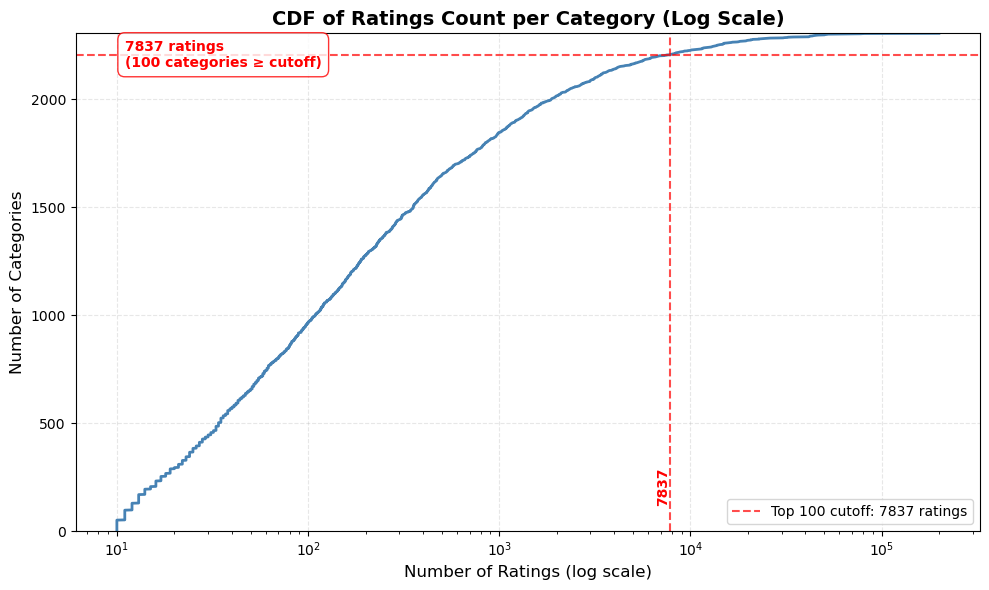

In [16]:
plt.figure(figsize=(10, 6))

sorted_ratings = np.sort(df_cat['num_reviews'])
n = len(sorted_ratings)
k = max(1, min(int(top_k_categories), n))
cumulative_count = np.arange(1, n + 1)

plt.plot(sorted_ratings, cumulative_count, linewidth=2, color='steelblue')
plt.xlabel('Number of Ratings (log scale)', fontsize=12)
plt.ylabel('Number of Categories', fontsize=12)
plt.title('CDF of Ratings Count per Category (Log Scale)', fontsize=14, fontweight='bold')
plt.xscale('log')
plt.grid(axis='both', alpha=0.3, linestyle='--')
plt.ylim(0, n)

cutoff_idx = max(0, n - k)
cutoff_value = sorted_ratings[cutoff_idx]
cutoff_count = cumulative_count[cutoff_idx]
categories_at_or_above = n - cutoff_idx

cutoff_label = f'Top {k} cutoff: {cutoff_value:.0f} ratings'
plt.axvline(cutoff_value, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label=cutoff_label)
plt.axhline(cutoff_count, color='red', linestyle='--', linewidth=1.5, alpha=0.7)

plt.text(cutoff_value, n * 0.05, f'{cutoff_value:.0f}',
         rotation=90, verticalalignment='bottom', horizontalalignment='right',
         fontsize=10, color='red', fontweight='bold')

plt.text(sorted_ratings[0] * 1.1, cutoff_count,
         f'{cutoff_value:.0f} ratings\n({categories_at_or_above} categories ≥ cutoff)',
         verticalalignment='center', horizontalalignment='left',
         fontsize=10, color='red', fontweight='bold',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8, edgecolor='red'))

plt.legend(loc='lower right', fontsize=10)
plt.tight_layout()
plt.show()